# Machine Learning in Python - Project 1

Due Friday, Feb 28th by 4 pm.

Hanzhe ZHANG, Chuzhou SHAO, Zihan ZHONG

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
#!pip install feature-engine

In [2]:
# Add any additional libraries or submodules below
from feature_engine.imputation import DropMissingData
from feature_engine.transformation import LogTransformer
# Data libraries
import pandas as pd
import numpy as np
from scipy import stats
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import Lasso

import pandas as pd
from IPython.display import display


In [3]:
def move_columns(arr, col_positions):
    arr = np.asarray(arr)  # Ensure input is a NumPy array
    num_rows, num_cols = arr.shape    
    # Identify columns to move and remaining columns
    moving_cols = arr[:, :len(col_positions)]  # The first few columns
    remaining_cols = arr[:, len(col_positions):]  # The rest of the columns
    # Create a list to hold reordered columns
    new_order = [None] * num_cols  # Placeholder for final arrangement
    # Place moving columns at their new positions
    for i, new_index in enumerate(col_positions):
        new_order[new_index] = moving_cols[:, i]
    # Fill remaining positions with original untouched columns
    rem_idx = 0
    for i in range(num_cols):
        if new_order[i] is None:  # Fill gaps with remaining columns
            new_order[i] = remaining_cols[:, rem_idx]
            rem_idx += 1
    # Stack the reordered columns to form the final array
    return np.column_stack(new_order)

In [4]:
def model_fit(m, X, y, plot = False):
    # Generate predictions using the model's predict method.
    y_hat = m.predict(X)  
    # Calculate Mean Squared Error (MSE) between actual and predicted values.
    MSE = mean_squared_error(y, y_hat)
    # Calculate Root Mean Squared Error (RMSE) as the square root of the MSE.
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    # Compute the R-squared value to assess the goodness of fit.
    Rsqr = r2_score(y, y_hat)
    # Round the metrics to 4 decimal places and store them in a tuple.
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    # Create a DataFrame to store actual values, predicted values, and the residuals.
    res = pd.DataFrame(
        data={'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    # If plotting is enabled, create diagnostic plots.
    if plot:
        # Set up the figure with specified dimensions.
        plt.figure(figsize=(8, 4))
        # First subplot: Observed vs. Fitted values.
        plt.subplot(121)
        # Plot a reference line (45-degree line) representing perfect predictions.
        sns.lineplot(
            x='y', y='y_hat', color="grey",
            data=pd.DataFrame(data={'y': [min(y), max(y)], 'y_hat': [min(y), max(y)]})
        )
        # Scatter plot of actual vs. predicted values.
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Observed vs Fitted values")
        # Second subplot: Residuals vs. Fitted values.
        plt.subplot(122)
        # Scatter plot of predicted values vs. residuals.
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted values vs Residuals")
        # Draw a horizontal dashed line at 0 to help visualize residual distribution.
        plt.hlines(
            y=0, xmin=np.min(y), xmax=np.max(y),
            linestyles='dashed', alpha=0.3, colors="black"
        )
        # Adjust the spacing of subplots for a cleaner layout.
        plt.subplots_adjust(left=0.0)
        # Add a super title displaying the computed metrics.
        plt.suptitle("Model (MSE, RMSE, Rsq) = " + str(Metrics), fontsize=10)
        # Display the plots.
        plt.show()  
    return MSE, RMSE, Rsqr# Return the performance metrics.

We will be using data collected by the Alzheimer’s Disease Neuroimaging Initiative, a longitudinal,
multi-center, observational study. The ADNI study aims to support the investigation and devel-
opment of treatments that slow or stop the progression of Alzheimer’s disease (AD). Researchers
at over 60 clinical sites in the USA and Canada collect data to study the progression of AD in the
human brain across normal aging, mild cognitive impairment (MCI), and Alzheimer’s disease and
dementia. This large-scale database combines clinical, demographic, imaging, biological, and omics
data for thousands of patients. A much reduced, simplified version of the data will be used for this
project, and the data have been provided in the file adnidata.csv

Let's start by reading in the data.

In [5]:
# Load data in easyshare.csv
data = pd.read_csv("adnidata.csv")

# Introduction
As part of ongoing efforts to mitigate the impact of dementia and Alzheimer’s disease, we have investigated predictive models for early identification of individuals at higher risk of cognitive decline. Drawing from the Alzheimer’s Disease Neuroimaging Initiative (ADNI)—a rich, longitudinal dataset containing clinical, demographic, genetic, and MRI-derived features—we focused on forecasting the 24-month follow-up cognitive score (ADAS-Cog 13). Our aim is to enable more targeted interventions and resource allocation by identifying people who might benefit most from early clinical trials or therapies.

In this report, we present a baseline linear regression model for comparison and demonstrate that regularized methods (particularly Lasso Regression) yield stronger and more interpretable results. Our findings suggest several key predictors (e.g., baseline ADAS13, volumetric measures, APOE4 genotype) are closely linked to cognitive outcomes. While no model can fully capture the complexity of dementia, these approaches offer actionable insights that may guide health professionals and policymakers in better screening, prioritizing interventions, and ultimately improving patient care.

# Exploratory Data Analysis and Feature Engineering

## Overview and Data Description

We began by examining the dataset, which contains 1,038 instances but fewer non-null values for some key features such as Ventricles, Hippocampus, and other brain volumes (≈890 observations). This suggests missing data for about 14% of these volumetric measurements. We also identified several categorical (text-based) attributes (e.g., DX.bl, APOE4) that require encoding before modeling.

To ensure the dataset was model-ready, we dropped two columns (Unnamed: 0 and RID) that provided no predictive signal. After that, we checked for (and found) no duplicated rows, but did identify missing data in multiple brain-measure columns (Ventricles, Hippocampus, WholeBrain, Entorhinal, Fusiform, MidTemp, ICV) as well as a few entries in APOE4.

In [6]:
# Drop irrelevant columns
data = data.drop("Unnamed: 0", axis=1).drop("RID", axis=1)

# Check for duplicates
print("There are {} duplicated observations".format(data.duplicated().sum()))

There are 0 duplicated observations


## Data Visualization and Initial Findings

### Histograms of Core Features
We then generated a grid of histograms to inspect each feature’s distribution:

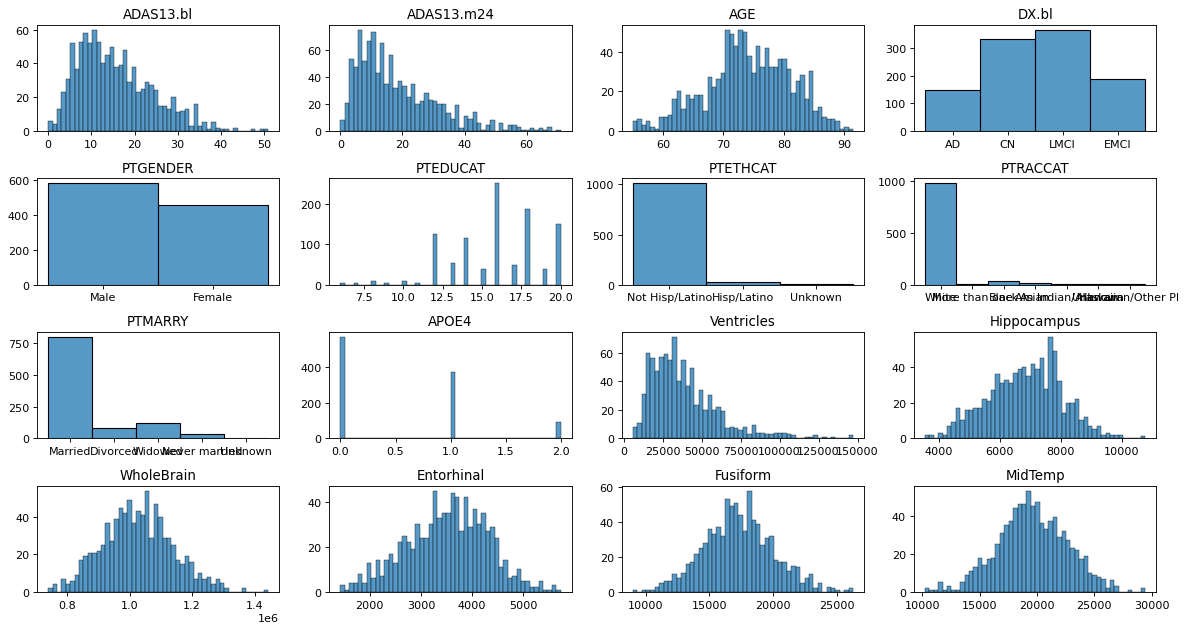

In [7]:
fig, axes = plt.subplots(figsize=(15,8), ncols=4, nrows=4)
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.histplot(data = data.iloc[:, i], bins=50, ax=ax)
    ax.set_title(data.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

Many distributions appeared heavy-tailed or skewed. For instance, columns like Ventricles suggested a strong right skew, potentially benefiting from log or Box-Cox transforms.

###  Correlation Heatmap

Next, we examined pairwise correlations among numeric variables (Figure 2.2) to uncover major relationships:

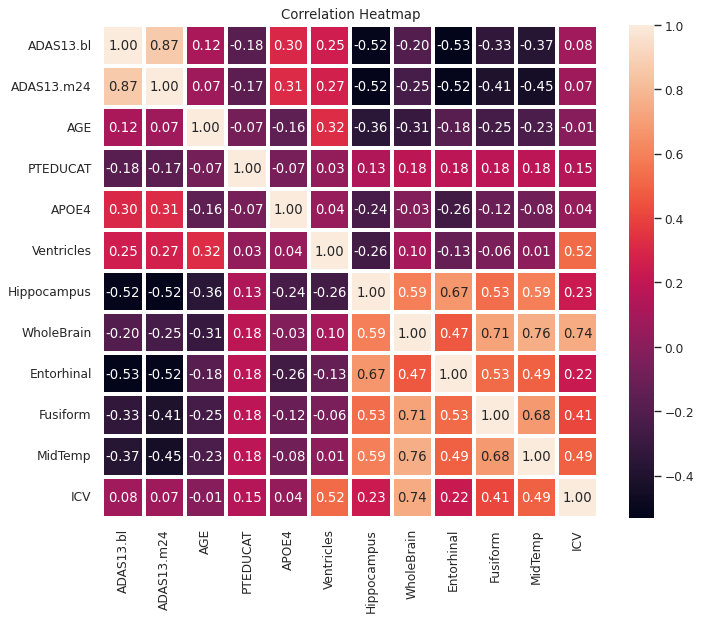

In [8]:
sns.set(rc={'figure.figsize': (10, 8)})
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f', linewidths=2)
plt.title("Correlation Heatmap")
plt.show()

Key findings:

- ADAS13.bl strongly correlates with ADAS13.m24 (r ≈ 0.87), indicating that baseline cognitive impairment predicts follow-up impairment.
- Hippocampus correlates negatively with ADAS13 (r ≈ –0.52), consistent with hippocampal atrophy in Alzheimer’s.
- APOE4 shows a moderate link to ADAS13 (r ≈ 0.3), confirming its known genetic risk factor status.
- Ventricles shows a noticeable positive correlation (r ≈ 0.27) with ADAS13.m24, reflecting the role of brain atrophy in declining cognition.

### Pair Plot

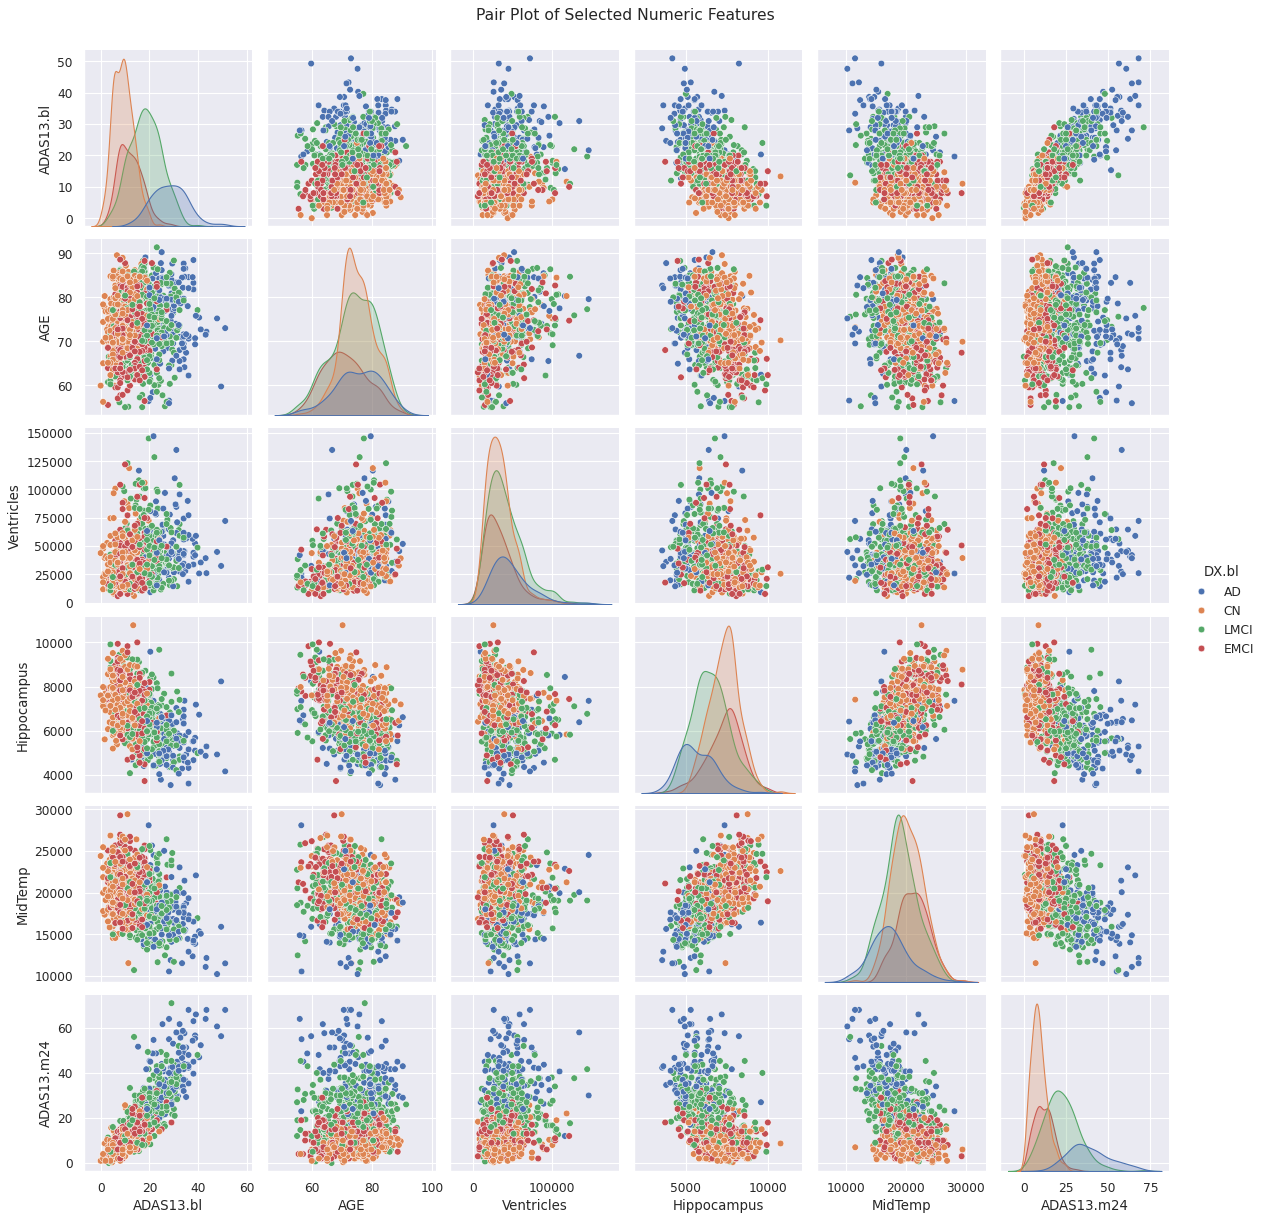

In [9]:
numeric_feats = [
    "ADAS13.bl", "AGE", "Ventricles", 
    "Hippocampus", "MidTemp", "ADAS13.m24"
]
# 1. Pairplot
sns.pairplot(
    data=data, 
    vars=numeric_feats, 
    hue="DX.bl",       # color by baseline diagnosis
    diag_kind="kde"    # kernel density on diagonal
)
plt.suptitle("Pair Plot of Selected Numeric Features", y=1.02, fontsize=14)
plt.show()

We selected ADAS13.bl and ADAS13.m24 due to their strong correlation (r ≈ 0.87), showing how baseline cognition predicts follow-up impairment, while Hippocampus (r ≈ -0.52) and MidTemp (r ≈ -0.45) capture memory-related atrophy associated with higher ADAS13 scores. Ventricles (r ≈ 0.27) highlights how increased atrophy links to worse outcomes, and AGE, though less strongly correlated, remains a fundamental risk factor for Alzheimer’s disease progression.

In [10]:
# 2. Summary Statistics by Diagnosis

# Adjust display settings for full output
pd.set_option('display.max_rows', None)    # Show all rows
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.width', None)       # Adjust display width for full view
pd.set_option('display.max_colwidth', None) # Show full column width

# Now display the summary statistics
print("Summary Statistics Grouped by Diagnosis")
summary_stats = data.groupby("DX.bl")[numeric_feats].agg(["mean","std","min","max","count"])
display(summary_stats)
# Group by DX.bl and compute basic stats

Summary Statistics Grouped by Diagnosis


ADAS13.bl                                      AGE                  \
            mean       std    min    max count       mean       std   min   
DX.bl                                                                       
AD     28.181361  7.202936  12.67  51.00   147  75.391156  7.611787  55.9   
CN      9.196497  4.135576   0.00  24.00   334  75.130240  5.593471  56.2   
EMCI   12.063158  4.912592   3.00  29.00   190  71.043684  7.182705  55.5   
LMCI   18.344169  6.515156   3.00  39.67   367  74.122071  7.407995  55.0   

                     Ventricles                                        \
        max count          mean           std     min       max count   
DX.bl                                                                   
AD     90.3   147  47941.208696  24913.713881  9166.0  147064.0   115   
CN     89.6   334  34284.885246  17524.722751  5834.0  118875.0   305   
EMCI   88.6   190  34112.204678  20435.780824  5650.0  122117.0   171   
LMCI   91.4   367  41977.903333  23459.547630  7801.0  145115.0   300   

       Hippocampus                                           MidTemp  \
              mean          std     min      max count          mean   
DX.bl                                                                  
AD     5676.695652  1096.293958  3548.0   9572.0   115  17308.226087   
CN     7336.265574   907.112201  5160.0  10769.0   305  20249.318033   
EMCI   7348.257310  1086.417655  3731.0   9993.0   171  21155.502924   
LMCI   6518.026667  1125.128178  4087.0   9902.0   300  18985.650000   

                                           ADAS13.m24                    \
               std      min      max count       mean        std    min   
DX.bl                                                                     
AD     3254.299752  10234.0  28103.0   115  38.601429  12.256228  12.00   
CN     2623.187567  11546.0  29435.0   305   8.911287   4.743137   0.33   
EMCI   2567.463361  15686.0  29292.0   171  11.773684   5.752050   2.00   
LMCI   2909.290301  10708.0  26705.0   300  22.269864  10.145662   0.00   

                    
         max count  
DX.bl               
AD     68.00   147  
CN     25.67   334  
EMCI   32.00   190  
LMCI   71.00   367

These grouped summary statistics reveal a clear relationship between baseline diagnosis and both cognitive scores and volumetric measures. At baseline, AD participants show the highest ADAS13 scores (mean≈28), alongside greater ventricular volume (~47k mm³) and lower hippocampal volume (~5677 mm³), which indicates more atrophy compared to other groups. Conversely, CN participants exhibit the lowest baseline ADAS13 (mean≈9), with relatively larger hippocampal (~7336 mm³) and middle temporal volumes (~20249 mm³). EMCI and LMCI fall between these extremes. After 24 months, the trends persist—ADAD’s mean ADAS13 rises to ~38, while CN remains at ~9, reflecting different trajectories of cognitive decline across diagnoses. Above all, the data underscore how advancing cognitive impairment correlates with both higher ADAS-Cog scores and, typically, reduced brain structure volumes.

## Handling Missing Data

We discovered that some columns like APOE4 had very few missing values (n=5), while volumetric measures had many (n≈147-148 missing). Our strategy split these cases:

- Minor Missingness: For APOE4 and a few columns such as ICV (missing 8 values), we replaced missing entries with a median or mean value.
- Major Missingness: For rows missing critical volumetric data (relatively large chunk, ~14%), we dropped them if it wouldn’t cause bias.


In [11]:
features = data.columns  # capture all columns
X = data.values          # convert the entire DataFrame (all columns) to a NumPy array
missing_counts = pd.DataFrame(X, columns=features).isna().sum()
print("Number of missing values in each column:")
print(missing_counts)

Number of missing values in each column:
ADAS13.bl        0
ADAS13.m24       0
AGE              0
DX.bl            0
PTGENDER         0
PTEDUCAT         0
PTETHCAT         0
PTRACCAT         0
PTMARRY          0
APOE4            5
Ventricles     147
Hippocampus    147
WholeBrain     148
Entorhinal     147
Fusiform       147
MidTemp        147
ICV              8
dtype: int64


Then split our features from our target variable in the data set.

In [12]:
# Drop target column from data, storing in 'X'
X = data.drop("ADAS13.m24", axis=1)
# Print the remaining features
print("Features after dropping 'ADAS13.m24':")
print(list(X.columns))
# Optionally, convert to NumPy arrays if needed
features = list(X.columns)
X = X.values
# Now extract your target 'y'
y = data["ADAS13.m24"].values

Features after dropping 'ADAS13.m24':
['ADAS13.bl', 'AGE', 'DX.bl', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']


We used a SimpleImputer for columns with few missing entries and removed rows for columns with widespread missingness:



In [13]:
num_imputer = SimpleImputer(strategy="mean")
num_cols = [8,15]
num_cols_imputer = ColumnTransformer(
    [("num", num_imputer,num_cols )],
    # don't touch all other columns, instead concatenate it on the end of the
    # changed data.
    remainder = "passthrough"
) 
X_ = num_cols_imputer.fit_transform(X)

X_ = pd.DataFrame(move_columns(X_,num_cols), columns = features)

dmd = DropMissingData()
dmd = dmd.fit(X=X_, y=y)
X_transformed = dmd.transform(X=X_)
# Find remaining row indices
valid_indices = X_.dropna().index  # Get indices of retained rows
# Filter y to match X__
y_ = y[valid_indices]

## Feature Engineering
### Count-like Variables
Besides dealing with missing data, we identified certain count-like volumetric variables—Ventricles, Hippocampus, WholeBrain, Entorhinal, Fusiform, MidTemp, ICV, and PTEDUCAT (education years). A probability plot indicated strong right-skew (particularly for Ventricles):

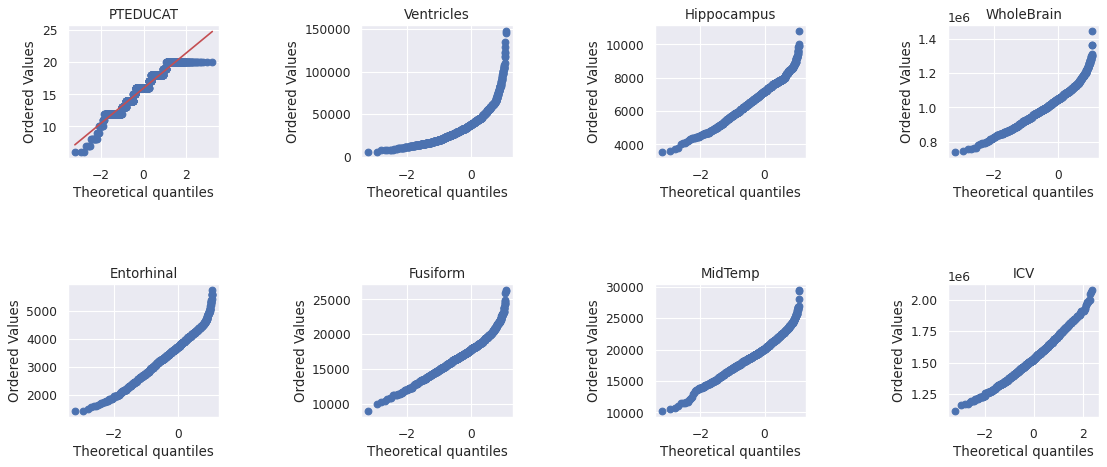

In [14]:
plt.figure(figsize=(14,6))

plt.subplot(2,4, 1) 
stats.probplot(data['PTEDUCAT'], dist="norm",plot=plt)
plt.title("PTEDUCAT")
plt.subplot(2,4, 2) 
stats.probplot(data['Ventricles'], dist="norm",plot=plt)
plt.title("Ventricles")
plt.subplot(2,4,3) 
stats.probplot(data['Hippocampus'], dist="norm",plot=plt)
plt.title("Hippocampus")
plt.subplot(2,4,4) 
stats.probplot(data['WholeBrain'], dist="norm",plot=plt)
plt.title("WholeBrain")
plt.subplot(2,4,5) 
stats.probplot(data['Entorhinal'], dist="norm",plot=plt)
plt.title("Entorhinal")
plt.subplot(2,4,6) 
stats.probplot(data['Fusiform'], dist="norm",plot=plt)
plt.title("Fusiform")
plt.subplot(2,4,7) 
stats.probplot(data['MidTemp'], dist="norm",plot=plt)
plt.title("MidTemp")
plt.subplot(2,4,8) 
stats.probplot(data['ICV'], dist="norm",plot=plt)
plt.title("ICV")

plt.tight_layout(h_pad = 5, w_pad = 5)
plt.show()

We can see `Ventricles` is clearly having a right skewed pattern.
We will apply box-cox transformation to this attribute as an example:

0.07


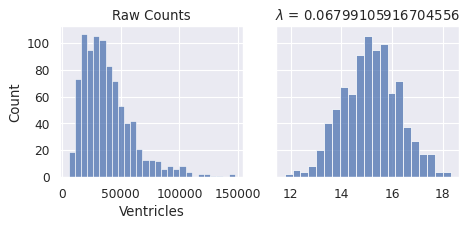

In [15]:
attribute_name = 'Ventricles'

box_,params= stats.boxcox(X_transformed[attribute_name].astype(float), lmbda = None)
print(round(params, 2))

fig, axes = plt.subplots(figsize = (6,3), ncols = 2, nrows=1, sharey = True)
axes = axes.flatten()
sns.histplot(data = X_transformed[attribute_name], ax = axes[0])
axes[0].set_title("Raw Counts")
for i, lmbda in enumerate([params]):
    box_ = stats.boxcox( X_transformed[attribute_name].astype(float), lmbda = lmbda)
    sns.histplot(data = box_, ax = axes[i + 1])
    axes[i + 1].set_title("$\lambda$ = {}".format(lmbda))
    
plt.tight_layout()
plt.show()

Implication: A Box-Cox transform with $\lambda\approx 0.07$ or a log transform was tested to stabilize variance.

## Categorical Encoding

In our dataset, DX.bl (baseline diagnosis) and APOE4 (genotype marker) are categorical variables. To use them in a regression model, we must encode these text-based features into numeric form. We do this via one-hot encoding in a scikit-learn pipeline, ensuring new categories don’t cause errors and that missing values are handled consistently.

In [16]:
cat_cols = [2, 3, 5, 6, 7]

# Build a pipeline for imputation + one-hot encoding
cat_pipeline = Pipeline([
    ("cat_impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("cat_encode", OneHotEncoder(handle_unknown="ignore"))
])

# Apply the pipeline to just these categorical indices
preprocessor = ColumnTransformer([
    ("cat_transform", cat_pipeline, cat_cols)
], remainder="passthrough")  # any non-categorical columns pass through unchanged

# Example usage
X_encoded = preprocessor.fit_transform(X)

print("After encoding catcols = [2,3,5,6,7], shape is:", X_encoded.shape)

After encoding catcols = [2,3,5,6,7], shape is: (1038, 32)


Columns indexed by **2**, **3**, **5**, **6**, and **7** in this dataset represent non-numeric (text-based) features that require encoding before modeling. Specifically, **index 2 (DX.bl)** indicates the participant’s clinical diagnosis at baseline, with possible categories such as cognitively normal (CN), early mild cognitive impairment (EMCI), late mild cognitive impairment (LMCI), and Alzheimer’s disease (AD). **Index 3 (PTGENDER)** shows the participant’s self-reported gender, typically male or female. **Index 5 (PTETHCAT)** captures ethnicity categories such as Hispanic/Latino, not Hispanic/Latino, or unknown, while **index 6 (PTRACCAT)** details race with potential values including white, black, Asian, American Indian/Alaskan, Hawaiian/other Pacific Islander, more than one, or unknown. Lastly, **index 7 (PTMARRY)** reflects the participant’s marital status at baseline, for instance, married, single, divorced, or widowed.

## Splitting Data into Training and Test Sets

Finally, two key steps prepared the data for modeling: Dropping/Encoding Columns: We combined all relevant columns into X, excluding the target variable ADAS13.m24. Train-Test Split: We reserved 20% of our data for final evaluation.


In [17]:
# Define features and target
X = data.drop("ADAS13.m24", axis=1)
y = data["ADAS13.m24"].copy()

# Convert to arrays or keep as DataFrame as needed
X = X.values
y = y.values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (712, 16)
y_train: (712,)
X_test: (178, 16)
y_test: (178,)


# Model Fitting and Tuning

## Overview of Approaches Considered
We explored several modeling strategies, including:

Baseline Linear Regression with all features (using both Box-Cox and Log transformations to handle skewed variables).
Regularized Linear Models (e.g., Ridge, Lasso, ElasticNet), where a penalty was applied to the coefficients.
Polynomial / Interaction Terms for capturing non-linear relationships (briefly attempted).
After preliminary experiments on our training set (using cross-validation to compare MSE/RMSE), we discarded some models with higher-order interactions due to overfitting and complexity. Ridge offered slight improvements over the baseline but did not significantly simplify or outperform another alternative. Lasso yielded good performance with the added benefit of sparsity (coefficients forced to zero), aiding interpretability.

Note: We do not include detailed code or lengthy explanations for these rejected approaches. Instead, we focus on our final chosen model and its tuning.



### Baseline model

Our first task is to fit a baseline model which we will be able to use as a point of comparison for our subsequent models. A good candidate for this is a simple linear regression model that includes all of our features.

In [18]:
def boxcoxarray(X, y=None, lmbda=None):
    X_ = X.copy()
    for i in range(X.shape[1]):
        if lmbda == None:
            X_[:,i], bc_params_ = stats.boxcox(X_[:,i], lmbda = lmbda)
        else:
            X_[:,i] = stats.boxcox(X_[:,i], lmbda = lmbda)
    return X_
# Creating our transformer from the pre-defined boxcoxarray callable function:
boxtransformer = FunctionTransformer(boxcoxarray, validate = True)

In [19]:
def model_plot(model,if_plot = False):
    lm_metrics_train = model_fit(model, X_train, y_train, plot=if_plot)
    lm_metrics_test = model_fit(model, X_test, y_test, plot=if_plot)
    print('Training MSE:',lm_metrics_train[0])
    print('Test MSE:',lm_metrics_test[0])


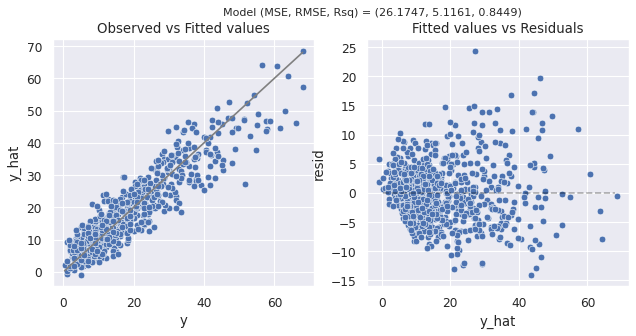

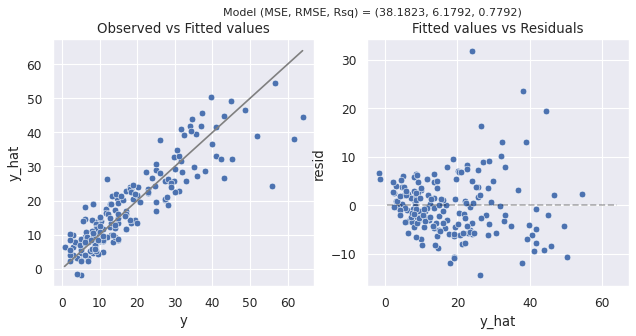

Training MSE: 26.17472168419531
Test MSE: 38.18231741892232


In [20]:
# Reg Pipe with log
set_config(display='diagram')

# Define column indices
numcols = [0, 1,8]
countcols = [4, 9, 10, 11, 12, 13, 14, 15]
catcols = [2,3,5,6,7]

# Reg Pipe with box-cox
num_pre = Pipeline([
    ("num_impute", SimpleImputer(strategy="median")),
    ("num_scale", StandardScaler())])

count_pre = Pipeline([
    ("num_impute", SimpleImputer(strategy="median")),
    #("num_transform", boxtransformer),
    ("num_transform", LogTransformer()),
    ("num_scale", StandardScaler())
])
cat_pre = Pipeline([
    ("cat_impute", SimpleImputer(strategy="constant")),
    ("cat_encode", OneHotEncoder( handle_unknown="ignore"))])

# Overall ML pipeline inlcuding all 
reg_pipe_fn = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols), 
        ("count_pre", count_pre, countcols),
        ("cat_pre", cat_pre, catcols)])), 

        ("model", LinearRegression())
])
reg_pipe_fn.fit(X_train,y_train)

reg_pipe_base = reg_pipe_fn
model_plot(reg_pipe_base,True)


## Development of the Final Model

Our final choice was Lasso Regression due to its:

Competitive Predictive Performance: Lasso returned the lowest cross-validated MSE in comparison to the other methods trialed.
Sparsity and Interpretability: By driving some coefficients to zero, it simplified the model and made the results easier to interpret.

### Lasso Pipeline
Below is the complete implementation of our final model, including all of the preprocessing steps. Notice we integrate our transformations into a single pipeline for clarity and reproducibility:

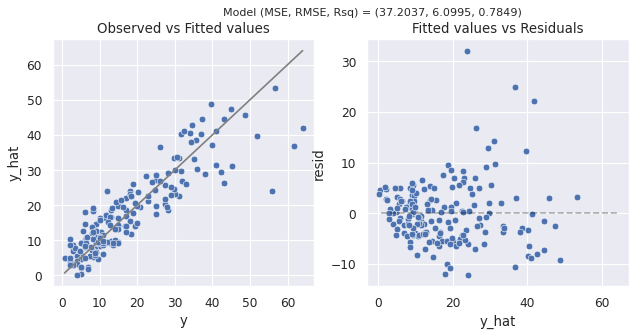

(37.20366878991655, 6.099481026277281, 0.7848678012380462)

In [21]:
# Selected alpha value 
alpha_val = 0.15

# Lasso pipeline
reg_pipe_lasso = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols), 
        ("count_pre", count_pre, countcols),
        ("cat_pre", cat_pre, catcols)])), 
        ("model", Lasso(alpha = alpha_val))
])
reg_pipe_lasso.fit(X_train, y_train)
model_fit(reg_pipe_lasso, X_test, y_test, plot = True)

## Parameter Tuning & Validation
We tuned the Lasso regularization parameter $\alpha$ using GridSearchCV with five-fold cross-validation:

Explored a range of $\alpha$ values (0.01 up to 1.0).
Selected the $\alpha$ that minimized the mean cross-validated MSE.
Validated our final model on a held-out test set, checking MSE, RMSE, and $R^2$.

### Tuning the Lasso penalty parameter

We can use the `GridSearchCV` function to tune our Lasso model and optimize the $\alpha$ hyperparameter (or use [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html), which combines `Lasso` and `GridSearchCV` but we will focus on the former). 

In [22]:
alphas = np.linspace(0.01, 1, num=100)

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)
# Pipeline
reg_pipe_lasso_cv = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols), 
        ("count_pre", count_pre, countcols),
        ("cat_pre", cat_pre, catcols)])), 
        ("model", Lasso())
])

gs_lasso = GridSearchCV(reg_pipe_lasso_cv,
                        param_grid={'model__alpha': alphas},
                        cv = cv,
                        scoring="neg_mean_squared_error")
gs_lasso.fit(X_train, y_train)

print( "alpha:", gs_lasso.best_params_)


alpha: {'model__alpha': 0.04}


In [23]:
gs_l = GridSearchCV(
    Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols), 
        ("count_pre", count_pre, countcols),
        ("cat_pre", cat_pre, catcols)])), 
        ("model", LinearRegression())]),
    param_grid = {},
    cv=cv,
    scoring="neg_mean_squared_error"
).fit(X_train, y_train)

print('CV MSE for baseline linear model', round(gs_l.best_score_ * -1,4))
print('CV MSE for lasso model', round(gs_lasso.best_score_ * -1,4))

CV MSE for baseline linear model 28.2046
CV MSE for lasso model 28.0739


In this case the best lasso model does produce a smaller CV MSE. This suggests that we should choose `alpha=0.04`.

## Comparison with Baseline

As required, we briefly compare our final Lasso model to the baseline linear regression, which is a simple model using all features and the same data preprocessing. For completeness, we also provide results for Ridge and ElasticNet. The table below outlines the test-set performance of each model in terms of $MSE$, $RMSE$, and $R^2$. Notably, Lasso achieves both a lower $MSE$ (37.40 vs. 38.18) and a higher $R^2$ (0.78 vs. 0.78 for baseline, rounded as shown), thereby outperforming the baseline linear regression in terms of accuracy and interpretability. By shrinking certain coefficients to zero, Lasso yields a less complex and more transparent model—an important advantage for identifying critical risk factors in cognitive decline.

In [24]:
df = pd.DataFrame(
    [["Baseline Linear", 38.1823, 6.1792, 0.7792],["Ridge",           37.8122, 6.1492, 0.7813],["Lasso",           37.3989, 6.1155, 0.7837],
    ["ElasticNet",      37.7106, 6.1409, 0.7819]], columns=["Model", "MSE", "RMSE", "R²"])
styled_df = (
    df.style
    .hide(axis='index')  # Hide row indices
    .set_caption("Summary of Model Performance")
    .background_gradient(cmap='Blues'))
#display(styled_df)
print(df.to_string(index=False))

          Model     MSE   RMSE     R²
Baseline Linear 38.1823 6.1792 0.7792
          Ridge 37.8122 6.1492 0.7813
          Lasso 37.3989 6.1155 0.7837
     ElasticNet 37.7106 6.1409 0.7819


# Discussion & Conclusions

Our final model uses Lasso regression, a technique that delivered slightly better performance than simpler linear regression and other regularized methods. By shrinking certain coefficients to zero, Lasso pinpoints a handful of key predictors while removing those with minimal impact. Notably, baseline ADAS13 scores, selected brain region volumes (e.g., hippocampus), and APOE4 genotype emerged as crucial indicators of future cognitive decline. For health officials and charity directors, this model offers a practical way to identify higher-risk individuals who may benefit most from focused support or early enrollment in therapeutic trials.

Despite these benefits, we acknowledge limitations. First, our dataset reflects only a specific group of patients and does not encompass all personal, lifestyle, or socio-economic drivers of dementia risk. As a result, predictions from this model cannot establish causality and might not generalize perfectly to all populations. Second, omitted variables such as diet, mental health factors, or environmental exposures may further refine risk estimation if included.

In light of these issues, we recommend collecting richer data—for example, on physical activity or social engagement—and retraining the model periodically as fresh information emerges. Meanwhile, clinicians could use the interpretable outputs of Lasso regression to screen vulnerable individuals, direct them to specialized programs, and promote earlier interventions. Ultimately, while our model is not flawless, it provides a clear, evidence-based process for prioritizing resources and improving care for those at risk of cognitive decline.

In [25]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
[NbConvertApp] Support files will be in project1_files/
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Writing 90343 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1300552 bytes to project1.pdf
